# Product Pricing Chart Case Study
## Product A Pricing Chart

- Product A has a raw material cost of around \$7 and takes about 30 - 45 minutes of processing time to complete.
- Product starts at 35 dollars and vendor is charging 5 dollars for each additional color used in construction.


In [269]:
# products start at $35 and cost $5 extra for each additional color
import numpy as np
# Define constants
BASE_PRICE = 35
DEFAULT_LENGTH = 12
DEFAULT_COLOR_NUM = 1
DEFAULT_WEIGHT = 8
MATERIAL_LOSS = 8
MATERIAL_PRICE_LIST = [14.94 / 2, 34.09 / 4, 48.60 / 10, 19.11 / 4]
MATERIAL_PRICE = np.mean(MATERIAL_PRICE_LIST)
print(f"MATERIAL_PRICE: ${MATERIAL_PRICE.round(2)}")

MATERIAL_PRICE: $6.41


### Generating Test Data for analysis
- Product has 3 parameters which can be customized for each user basis. Length, Weight, and Color.
- In my generated test data I am maxing out on a length of 20 inches.

In [270]:
# Generating test data
import pandas as pd

weight_list = list(range(6, 13))
length_list = list(range(6, 15))
color_list = list(range(1,10))
data = []

for weight in weight_list:
    for length in length_list:
            for color in color_list:
                if color < weight:
                    data.append([weight, length, color])


df = pd.DataFrame(columns=['weight', 'length', 'num_colors'], data=data)

df.head()

,weight,length,num_colors
0,6,6,1
1,6,6,2
2,6,6,3
3,6,6,4
4,6,6,5


In [271]:
# Adding building stats to df
generated_columns = ['get_segment_length', 'get_num_segments', 'get_num_units_raw']
df_build_stats = df.copy()
df_build_stats['get_segment_length'] = df['length'] + 8
df_build_stats['get_num_segments'] = df['weight'] / 2
df_build_stats['get_segments_per_color'] = df_build_stats['get_num_segments'] / df['num_colors']
df_build_stats['get_total_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_build_stats['get_num_units_raw'] = df_build_stats['get_total_length'] / INCHES_PER_COIL
df_build_stats['get_length_per_color'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']



#### Segment Length vs Material Count

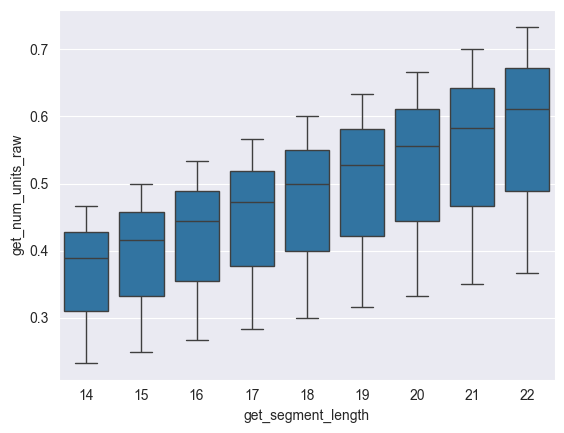

In [272]:
import seaborn as sns

sns.boxplot(data=df_build_stats, x='get_segment_length', y='get_num_units_raw');

#### Lowest Profit Items

In [273]:
# Verifying that there is still a profit margin in the worst case scenarios.
df_price = df.copy()
COST_PER_UNIT = (15 / 2) + 8 #Two units per order plus shipping and handling
INCHES_PER_UNIT = 15 * 12
PROCESS_TIME_PER_ORDER = .45
COST_PER_COLOR = 5
df_price['price'] = 35 + df_price['num_colors'] * COST_PER_COLOR
df_price['num_units'] = df_build_stats['get_num_units_raw'].round(1) * df_build_stats['num_colors']
df_price['num_units_rounded'] = np.ceil(df_price.num_units / 2) * 2
df_price['material_loss'] = df_price['num_units_rounded'] - df_price['num_units']
df_price['material_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_price['cost']= df_price['num_units'] * COST_PER_UNIT
df_price['profit']= df_price['price'] - df_price['cost']
df_price.sort_values(by=['profit'], ascending=True, inplace=True)
df_price.head()


,weight,length,num_colors,price,num_units,num_units_rounded,material_loss,material_length,cost,profit
476,12,14,9,80,6.3,8.0,1.7,132.0,97.65,-17.65
458,12,12,9,80,6.3,8.0,1.7,120.0,97.65,-17.65
467,12,13,9,80,6.3,8.0,1.7,126.0,97.65,-17.65
395,11,14,9,80,6.3,8.0,1.7,121.0,97.65,-17.65
457,12,12,8,75,5.6,6.0,0.4,120.0,86.80,-11.80


In [274]:
meanProfit = df_price.profit.mean()
print("Lowest Profit: ",df_price.profit.min().round(1))
print("Highest Profit: ",df_price.profit.max().round(2))
print("Mean Profit: ",df_price.profit.mean().round(2))
print("Median Profit: ",df_price.profit.median().round(2))
print("Hourly Profit: ", (df_price.profit.mean() / PROCESS_TIME_PER_ORDER).round(2))
print("Mean Material Loss: ",df_price.material_loss.mean().round(2))

Lowest Profit:  -17.6
Highest Profit:  44.5
Mean Profit:  23.81
Median Profit:  27.8
Hourly Profit:  52.91
Mean Material Loss:  0.96


#### Observations
- There is only a negative profit on one of the items in the chart it used some fairly unrealistic values.
- The mean profit for this data set is 23.81
- The units with the lowest profit all have weight > 10 and length > 11
- The mean material loss is .96 units, but assumes the client doesn't reuse any scrap materials.


### Profit Graph Plots

#### Profit by count

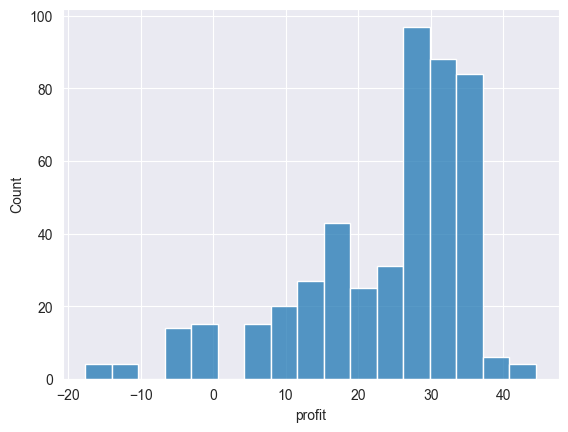

In [275]:
sns.histplot(x='profit', data=df_price);

#### Profit by Material Count

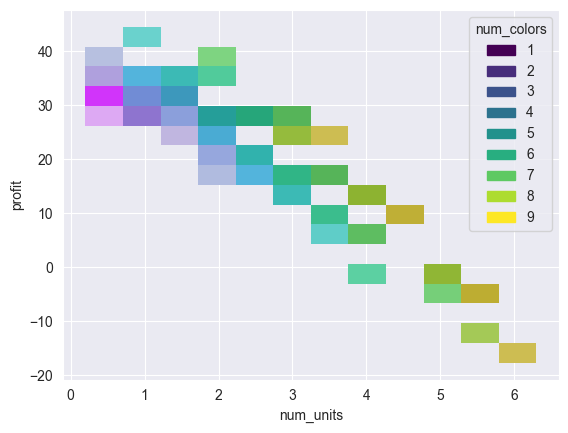

In [276]:


sns.histplot(data=df_price, x='num_units', y='profit', hue='num_colors', palette='viridis');


### Observations
- When num_units is greater than 4 or num_colors is more than 6 some orders stop being profitable.


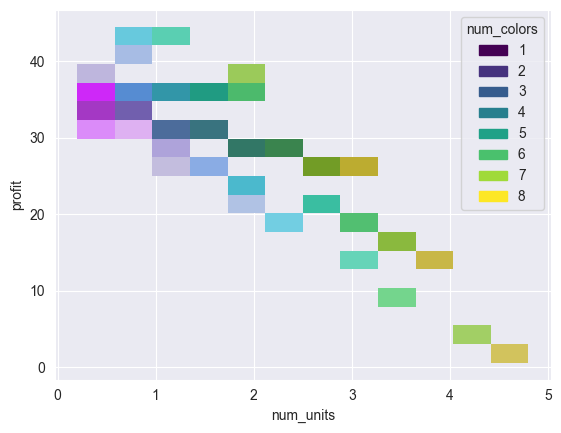

In [285]:
import seaborn as sns
df_light = df_price[df_price['weight'] < 10]
sns.histplot(data=df_light, x='num_units', y='profit', hue='num_colors', palette='viridis');

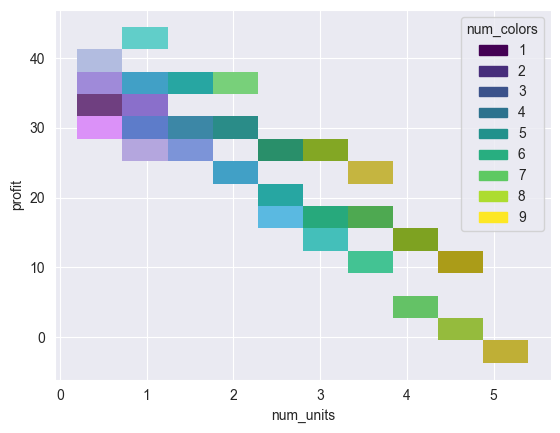

In [286]:
df_short = df_price[df_price['length'] < 12]
sns.histplot(data=df_short, x='num_units', y='profit', hue='num_colors', palette='viridis');

### Observations
- Limiting order weight to values less than 10 or length to values less than 12 unprofitable samples from the set.

### Conclusion
- Based on the observations this product should be fairly profitable for the client.
- Client should do additional research to find the best place to market their product.
- Vendor could eliminate unprofitable sales by one of the following:
- A. Putting a max limit on length and weight values for their orders.
- B. Adding a surcharge for orders that fall outside normal range.